# UNETR Implementation for Wrist Bone Segmentation
In this section, we focus on the UNETR architecture for segmenting wrist bones. UNETR combines convolutional neural networks (CNNs) with transformers to improve segmentation performance, especially in medical imaging tasks. It effectively captures both local and global features, making it ideal for detailed and accurate segmentation.

The UNETR model excels at handling complex anatomical structures, ensuring precise wrist bone segmentation. Its unique architecture maintains spatial hierarchies and adapts to variations within medical images. This implementation highlights UNETR's ability to deliver reliable results by leveraging both local and long-range context information, leading to better performance compared to traditional models.

### Importing Necessary Libraries

In [3]:
import os
from glob import glob
from monai.transforms import (
    Compose, LoadImaged, AddChanneld, ScaleIntensityRanged, RandFlipd,
    RandAffined, RandRotated, RandZoomd, NormalizeIntensityd, ToTensord, EnsureTyped, 
EnsureType,RandGaussianNoised,RandGaussianSmoothd,RandScaleIntensityd,RandShiftIntensityd,ScaleIntensityd
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism, first
from monai.networks.nets import UNETR
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import AsDiscrete, Activations
import torch
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from matplotlib import colors
from monai.metrics import SurfaceDistanceMetric


print("All libraries have been successfully Imported!!!")

All libraries have been successfully Imported!!!


### Data Loaders and Data Transformations

In [4]:
## CREATING PATHS TO UPLOAD OUR DATA
data_dir = '/workspace/data'

train_images = sorted(glob(os.path.join(data_dir, 'imagesTr', '*nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir, 'labelsTr', '*nii.gz')))

val_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
val_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)]

In [5]:
orig_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    ToTensord(keys=['image', 'label'])
])

# Defining training transforms
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=['image'], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    RandAffined(keys=['image', 'label'], prob=0.5, rotate_range=(0, 0, np.pi/12), scale_range = (0.1,0.1,0.1),
                mode=("nearest", "nearest")),  
    EnsureTyped(keys=['image', 'label']),
    ToTensord(keys=['image', 'label'])
])

# Defining validation transforms
val_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=['image'], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=['image', 'label']),
    ToTensord(keys=['image', 'label'])
])


In [6]:
# Creating datasets and dataloaders
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
orig_ds = Dataset(data=train_files, transform=orig_transforms)

In [7]:
orig_ds = Dataset(data=train_files, transform=orig_transforms)
orig_loader = DataLoader(orig_ds, batch_size = 2)

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size =2)

val_ds = Dataset(data=val_files, transform=train_transforms)
val_loader = DataLoader(val_ds, batch_size = 2)

test_patient = first(train_loader)
orig_patient = first(orig_loader)

In [8]:
print(torch.min(test_patient['image']))
print(torch.max(test_patient['image']))

tensor(0.)
tensor(1.)


### Comparing Original Image with Preprocessed Image and Labels
In this section, we compare the original images with their preprocessed counterparts and corresponding labels. This comparison highlights the impact of preprocessing on image quality and segmentation accuracy. Preprocessing steps such as normalization, augmentation, and transformation enhance the model's ability to accurately segment the wrist bones by improving the contrast and highlighting relevant features. This analysis is crucial for understanding how preprocessing contributes to the overall performance of the segmentation model.

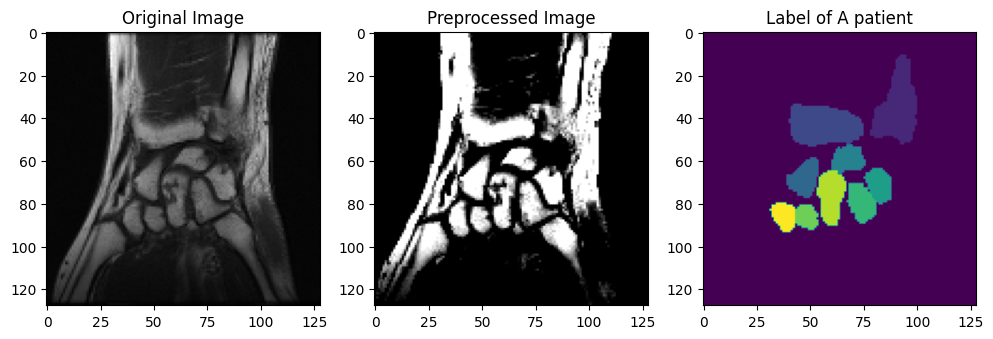

In [9]:
plt.figure('test',(12,6))


plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(orig_patient['image'][0,0,:,:,21], cmap = "gray")   #[b,c,w,h,s]

plt.subplot(1,3,2)
plt.title('Preprocessed Image')
plt.imshow(test_patient['image'][0,0,:,:,21], cmap = "gray")   #[b,c,w,h,s]

plt.subplot(1,3,3)
plt.title('Label of A patient')
plt.imshow(test_patient['label'][0,0,:,:,21])   #[b,c,w,h,s]


### UNETR MODEL TRAINING

In [361]:
sample_label = test_patient['label'][0, 0, :, :, 15].cpu().numpy()
unique_values = np.unique(sample_label)
print(f"Unique label values: {unique_values}")

# Checking if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining the UNETR model with specified parameters
model = UNETR(
    in_channels=1,
    out_channels=11,  # 10 bones + background
    img_size=(128, 128, 48),
    feature_size=32,
    hidden_size=384,
    mlp_dim=1024,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1 
).to(device)

# Defining the loss function
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

# Defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Defining the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# Defining metrics
dice_metric = DiceMetric(include_background=True, reduction="mean")
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=11)])
post_label = Compose([AsDiscrete(to_onehot=11)])

print("Model, loss function, optimizer, and metrics are set up.")

#====================================================================
print("Model Training Successfully started!!!")

# Early stopping parameters
patience = 30 # Number of epochs with no improvement after which training will be stopped
early_stop = False
counter = 0  # Counter for early stopping

# Training loop
max_epochs = 300  # Increased number of epochs
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# Initializing dictionary to store the best metrics for each class
best_class_metrics = {i: 0 for i in range(11)}  # assuming 11 classes including background

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_loader)} train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
            for val_data in val_loader:
                val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_outputs = sliding_window_inference(val_images, (128, 128, 48), 4, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)
            
            # Calculate metrics
            metric = dice_metric.aggregate().item()
            metric_batch = dice_metric_batch.aggregate()
            dice_metric.reset()
            dice_metric_batch.reset()
            
            metric_values.append(metric)

            # Save the best model based on the mean Dice metric
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
                counter = 0  # Reset early stopping counter
                # Update best metrics for each class
                for i in range(11):
                    best_class_metrics[i] = metric_batch[i].item()
            else:
                counter += 1  # Increment early stopping counter
            
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}")
            for i, dice in enumerate(metric_batch):
                print(f"Class {i} dice: {dice.item():.4f}")
            print(f"best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")
            
            # Early stopping check
            if counter >= patience:
                print("Early stopping triggered")
                early_stop = True
                break

    if early_stop:
        break

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

# Loading the best model for final evaluation
model.load_state_dict(torch.load("best_metric_model.pth"))
model.eval()

# Evaluating and printing the dice coefficient for every label achieved through the best model
with torch.no_grad():
    dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
    for val_data in val_loader:
        val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        val_outputs = sliding_window_inference(val_images, (128, 128, 48), 4, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        dice_metric_batch(y_pred=val_outputs, y=val_labels)
    
    metric_batch = dice_metric_batch.aggregate()
    dice_metric_batch.reset()

    print("Final per-class Dice metrics:")
    for i, dice in enumerate(metric_batch):
        print(f"Class {i} dice: {dice.item():.4f}")

Unique label values: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Model, loss function, optimizer, and metrics are set up.
Model Training Successfully started!!!
----------
epoch 1/250
1/20 train_loss: 0.9705
2/20 train_loss: 0.9492
3/20 train_loss: 0.9467
4/20 train_loss: 0.9401
5/20 train_loss: 0.9322
6/20 train_loss: 0.9344
7/20 train_loss: 0.9289
8/20 train_loss: 0.9283
9/20 train_loss: 0.9359
10/20 train_loss: 0.9103
11/20 train_loss: 0.9157
12/20 train_loss: 0.9286
13/20 train_loss: 0.9124
14/20 train_loss: 0.9123
15/20 train_loss: 0.9121
16/20 train_loss: 0.9059
17/20 train_loss: 0.9071
18/20 train_loss: 0.8996
19/20 train_loss: 0.9064
20/20 train_loss: 0.8912
epoch 1 average loss: 0.9234
----------
epoch 2/250
1/20 train_loss: 0.8928
2/20 train_loss: 0.8914
3/20 train_loss: 0.8927
4/20 train_loss: 0.8876
5/20 train_loss: 0.8794
6/20 train_loss: 0.8875
7/20 train_loss: 0.8840
8/20 train_loss: 0.8825
9/20 train_loss: 0.8976
10/20 train_loss: 0.8668
11/20 train_loss: 0.8664
12/20 train_loss: 0

### Evaluation of the Model
In this section, we evaluate the ensemble model's performance by calculating the Dice metric and Average Symmetric Surface Distance (ASSD) for each of the 10 wrist bones. These metrics provide insights into the segmentation accuracy and spatial agreement between predicted and actual bone structures.

### 1. Dice Metrics Calculation

In [9]:
# Loading the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR(
    in_channels=1,
    out_channels=11,  # 10 bones + background
    img_size=(128, 128, 48),
    feature_size=32,
    hidden_size=384,
    mlp_dim=1024,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1 
).to(device)

dice_metric = DiceMetric(include_background=True, reduction="mean")
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=11)])
post_label = Compose([AsDiscrete(to_onehot=11)])

# Loading the best model for final evaluation
model.load_state_dict(torch.load("best_metric_model_unetr.pth"))
model.eval()

# Function to calculate the mean and std deviation of dice scores
def calculate_mean_std(dice_scores):
    mean_dice = torch.mean(dice_scores, dim=0)
    std_dice = torch.std(dice_scores, dim=0)
    return mean_dice, std_dice

# Evaluating and printing the dice coefficient for every label achieved through the best model
with torch.no_grad():
    dice_metric_batch = DiceMetric(include_background=True, reduction="none")
    all_dice_scores = []

    for val_data in val_loader:
        val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        val_outputs = sliding_window_inference(val_images, (128, 128, 48), 4, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        # Calculating dice metric for each batch
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

        # Storing dice scores for the current batch
        batch_dice_scores = dice_metric_batch.aggregate()
        all_dice_scores.append(batch_dice_scores)

        # Resetting for the next batch
        dice_metric_batch.reset()

    # Converting list of tensors to a single tensor
    all_dice_scores = torch.cat(all_dice_scores, dim=0)

    # Calculating mean and standard deviation
    mean_dice, std_dice = calculate_mean_std(all_dice_scores)

    print("Final per-class Dice metrics:")
    for i, (mean, std) in enumerate(zip(mean_dice, std_dice)):
        print(f"Class {i} dice: {mean.item():.4f} +/- {std.item():.4f}")

Final per-class Dice metrics:
Class 0 dice: 0.9884 +/- 0.0023
Class 1 dice: 0.8043 +/- 0.0893
Class 2 dice: 0.8924 +/- 0.0364
Class 3 dice: 0.8781 +/- 0.0465
Class 4 dice: 0.8321 +/- 0.0631
Class 5 dice: 0.8167 +/- 0.0628
Class 6 dice: 0.8795 +/- 0.0380
Class 7 dice: 0.8312 +/- 0.0614
Class 8 dice: 0.9011 +/- 0.0247
Class 9 dice: 0.7610 +/- 0.1281
Class 10 dice: 0.8102 +/- 0.0514


### 2. Average Symmetric Surface Distance (ASSD)

In [12]:
# Loading the best model for final evaluation
model.load_state_dict(torch.load("best_metric_model_unetr.pth"))
model.eval()

# Function to calculate the mean and std deviation of metrics
def calculate_mean_std(metric_scores):
    mean_metric = torch.mean(metric_scores, dim=0)
    std_metric = torch.std(metric_scores, dim=0)
    return mean_metric, std_metric

# Evaluating and printing the ASSD for every label achieved through the best model
with torch.no_grad():
    surface_distance_metric_batch = SurfaceDistanceMetric(include_background=True, reduction="none")

    all_assd_scores = []

    for val_data in val_loader:
        val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
        val_outputs = sliding_window_inference(val_images, (128, 128, 48), 4, model)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        # Calculating ASSD for each batch
        surface_distance_metric_batch(y_pred=val_outputs, y=val_labels)
        batch_assd_scores = surface_distance_metric_batch.aggregate()
        all_assd_scores.append(batch_assd_scores)
        surface_distance_metric_batch.reset()

    # Converting list of tensors to a single tensor
    all_assd_scores = torch.cat(all_assd_scores, dim=0)

    # Calculating mean and standard deviation
    mean_assd, std_assd = calculate_mean_std(all_assd_scores)

    print("Final per-class ASSD metrics:")
    for i, (mean_a, std_a) in enumerate(zip(mean_assd, std_assd)):
        print(f"Class {i} ASSD: {mean_a.item():.4f} +/- {std_a.item():.4f}")

Final per-class ASSD metrics:
Class 0 ASSD: 0.2111 +/- 0.0543
Class 1 ASSD: 1.4407 +/- 0.7512
Class 2 ASSD: 0.9699 +/- 0.3079
Class 3 ASSD: 0.7603 +/- 0.3340
Class 4 ASSD: 1.2814 +/- 0.7287
Class 5 ASSD: 0.8295 +/- 0.3670
Class 6 ASSD: 0.7969 +/- 0.4038
Class 7 ASSD: 1.0609 +/- 0.6205
Class 8 ASSD: 0.6356 +/- 0.0697
Class 9 ASSD: 1.2159 +/- 0.5690
Class 10 ASSD: 0.8885 +/- 0.3596


#### Data Visualization
In this section, we visualize the predicted segmentation masks of the wrist bones. We display all the bones together and also visualize each bone individually to better understand the segmentation output and evaluate the accuracy of each predicted structure.

/opt/conda/lib/python3.10/site-packages/monai/transforms/post/array.py:176: UserWarning: `to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
  warnings.warn("`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.")


Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


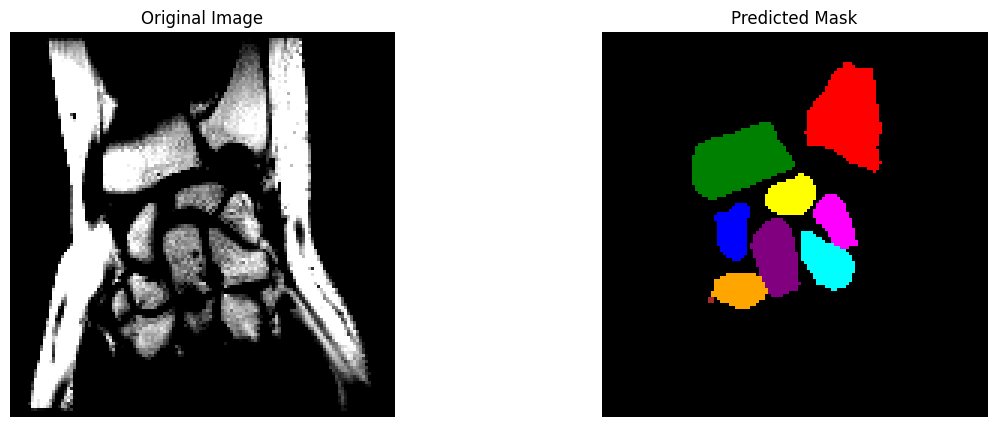

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


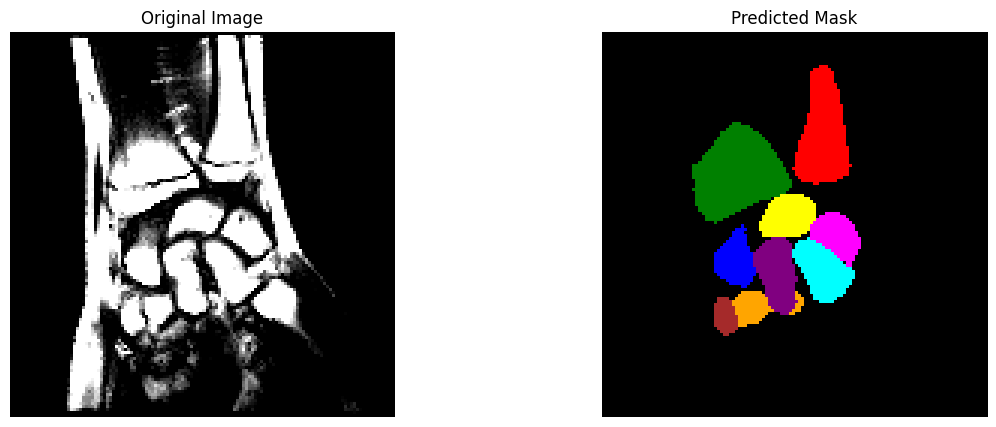

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


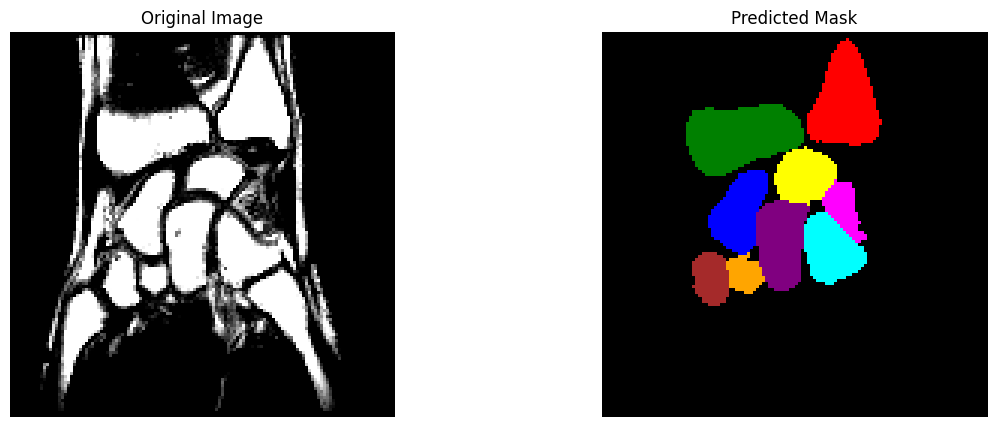

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


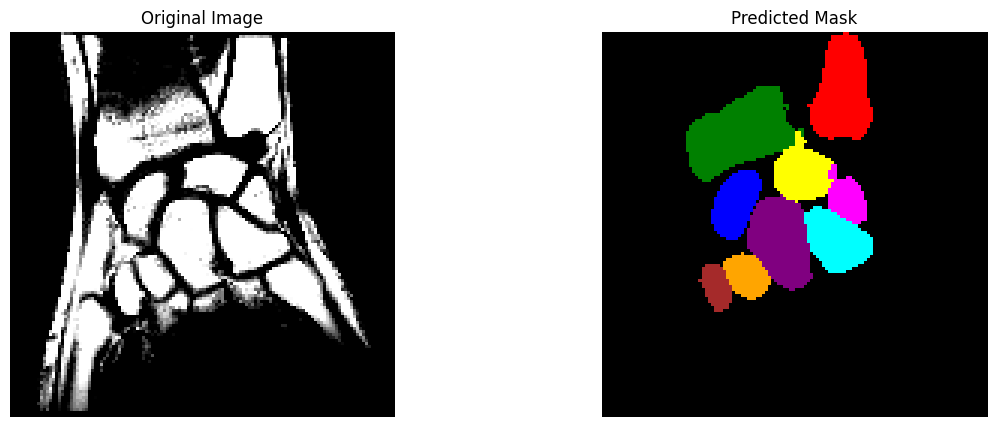

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


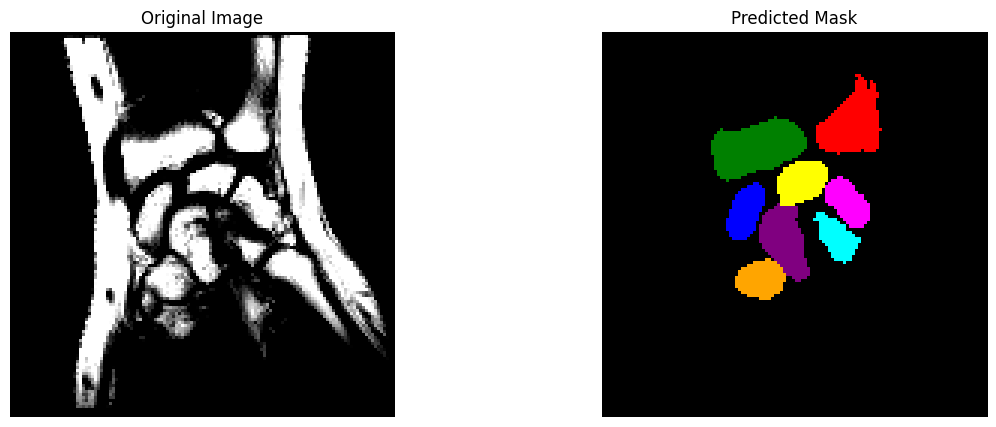

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


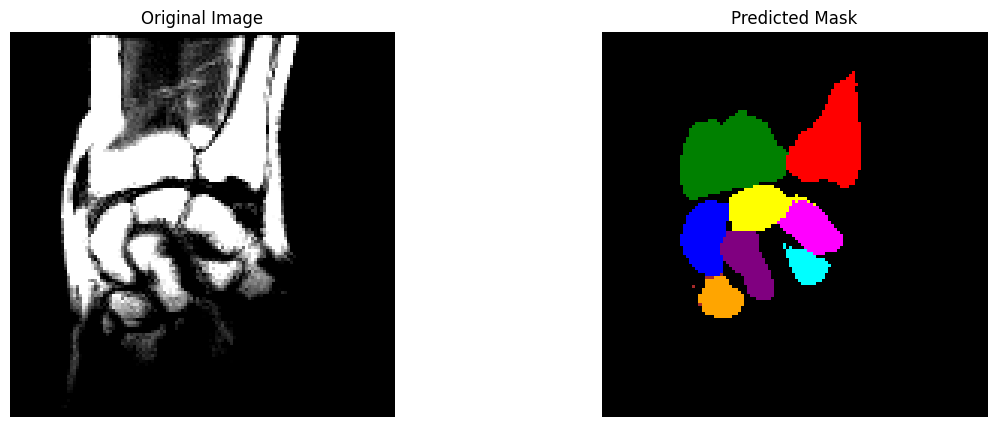

In [13]:
# Defining paths
data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks'  # Directory to save the predicted masks
os.makedirs(output_dir, exist_ok=True)

test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))

test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Loading the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR(
    in_channels=1,
    out_channels=11,  # 10 bones + background
    img_size=(128, 128, 48),
    feature_size=32,
    hidden_size=384,
    mlp_dim=1024,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1 
).to(device)

model.load_state_dict(torch.load("best_metric_model_unetr.pth", map_location=device))
model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Visualization function with custom colormap
def visualize_results(image, prediction, slice_num, num_classes=11):
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 'brown', 'pink'])
    bounds = np.linspace(0, num_classes, num_classes + 1)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image[0, 0, :, :, slice_num], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction[0, :, :, slice_num], cmap=cmap, norm=norm)
    plt.axis('off')

    plt.show()

# Running inference, save predicted masks, and visualize results
for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    with torch.no_grad():
        test_outputs = sliding_window_inference(test_images, (128, 128, 48), 4, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

    # Converting predictions to numpy
    test_outputs = torch.stack(test_outputs).cpu().numpy()

    # Debugging: Print statistics of the predictions
    print(f"Test output shape: {test_outputs.shape}")
    print(f"Unique values in test output: {np.unique(test_outputs)}")

    # Saving the predicted mask
    predicted_mask = test_outputs[0]  # Ensure correct shape selection
    original_image = nib.load(test_files[i]["image"])
    predicted_nifti = nib.Nifti1Image(predicted_mask, original_image.affine, original_image.header)
    nib.save(predicted_nifti, os.path.join(output_dir, f"predicted_mask_{i}.nii.gz"))

    # Visualizing the results
    slice_num = 25 # Change this value to visualize different slices
    visualize_results(test_images.cpu().numpy(), predicted_mask, slice_num)


Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


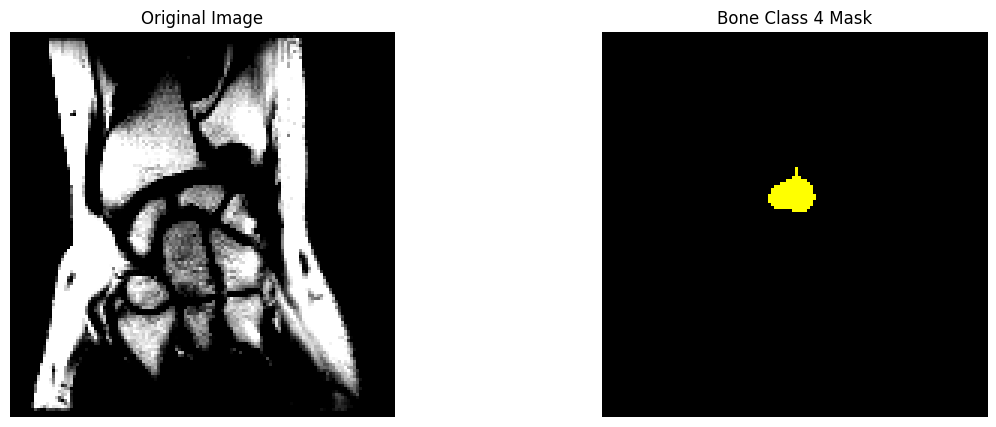

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


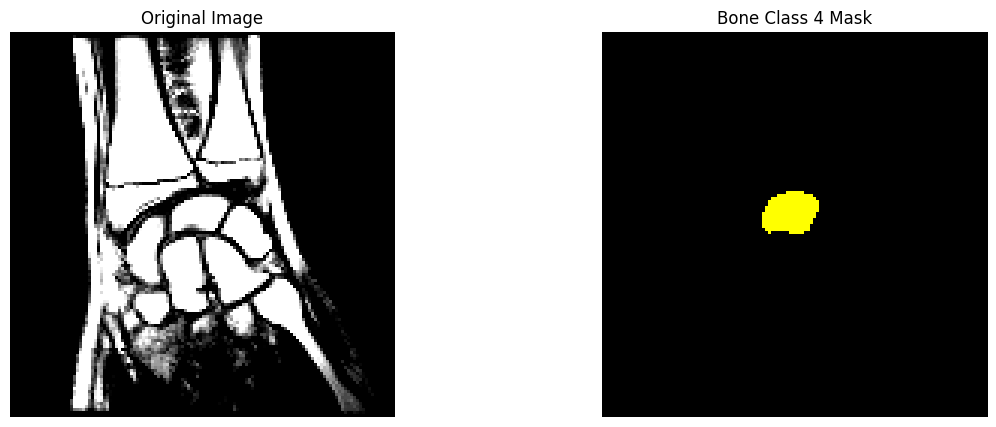

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


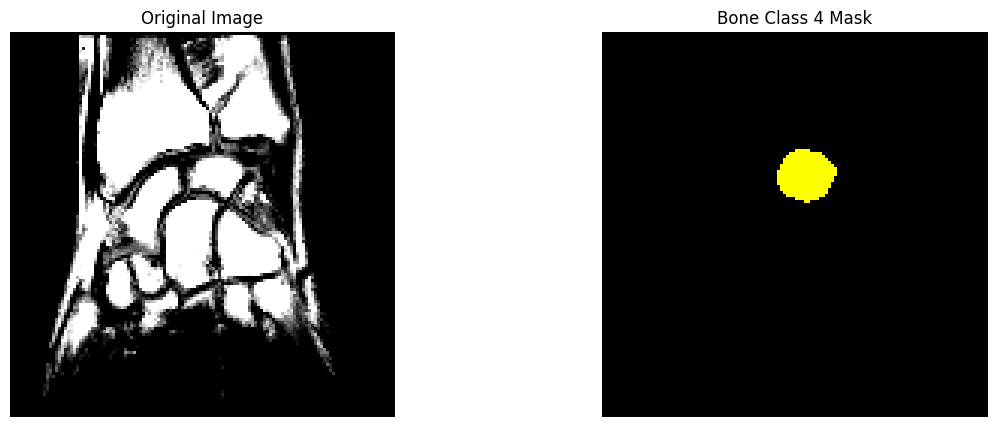

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


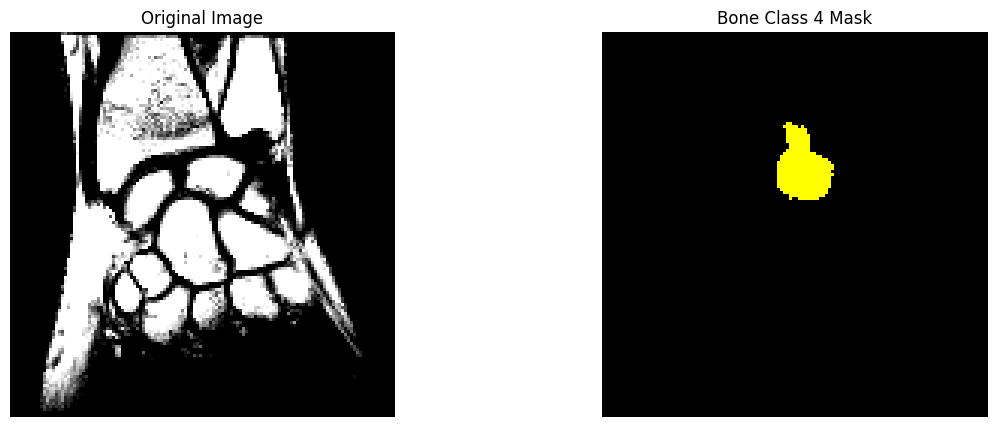

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


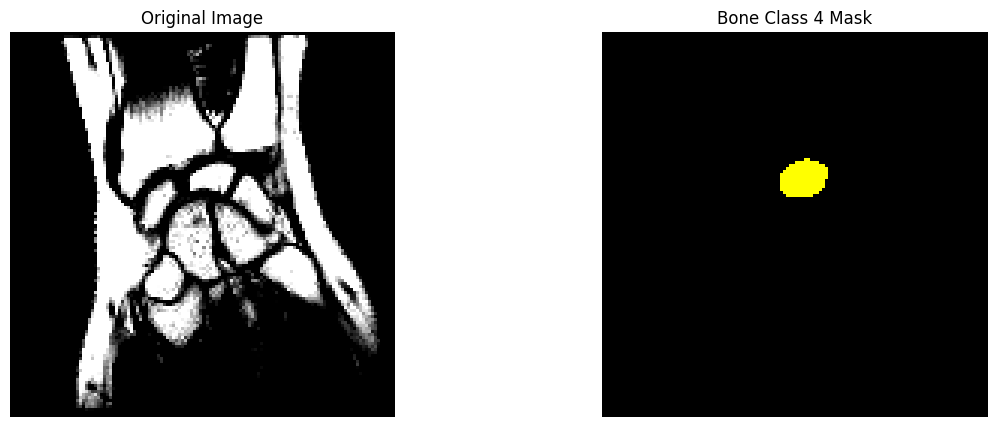

Test output shape: (1, 1, 128, 128, 48)
Unique values in test output: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


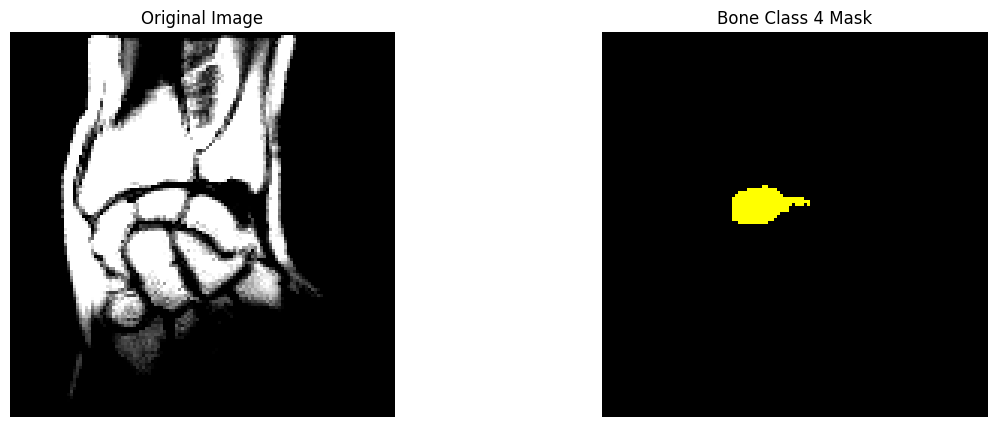

In [15]:
data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks'  
os.makedirs(output_dir, exist_ok=True)


test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))


test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Loading the trained SegResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR(
    in_channels=1,
    out_channels=11,  # 10 bones + background
    img_size=(128, 128, 48),
    feature_size=32,
    hidden_size=384,
    mlp_dim=1024,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1 
).to(device)

model.load_state_dict(torch.load("best_metric_model_unetr.pth", map_location=device))
model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Visualization function for a specific bone class
def visualize_single_bone(image, prediction, bone_class, slice_num):
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 'brown', 'pink'])
    bounds = np.linspace(0, 11, 12)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # Isolating the bone class from prediction
    bone_mask = (prediction == bone_class).astype(np.uint8) * bone_class  # Ensure correct class value

    plt.figure(figsize=(14, 5))

    # Displaying the original image slice
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image[0, 0, :, :, slice_num], cmap='gray')
    plt.axis('off')

    # Displaying the predicted bone mask slice
    plt.subplot(1, 2, 2)
    plt.title(f"Bone Class {bone_class} Mask")
    plt.imshow(bone_mask[0, :, :, slice_num], cmap=cmap, norm=norm)
    plt.axis('off')

    plt.show()

# Running inference, save predicted masks, and visualize results
bone_class_to_visualize = 4
for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    with torch.no_grad():
        test_outputs = sliding_window_inference(test_images, (128, 128, 48), 4, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

    # Converting predictions to numpy
    test_outputs = torch.stack(test_outputs).cpu().numpy()

    # Debugging: Print statistics of the predictions
    print(f"Test output shape: {test_outputs.shape}")
    print(f"Unique values in test output: {np.unique(test_outputs)}")

    # Saving the predicted mask
    predicted_mask = test_outputs[0]  
    original_image = nib.load(test_files[i]["image"])
    predicted_nifti = nib.Nifti1Image(predicted_mask, original_image.affine, original_image.header)
    nib.save(predicted_nifti, os.path.join(output_dir, f"predicted_mask_{i}.nii.gz"))

    # Visualizing the results for the selected bone class
    slice_num = 22  
    visualize_single_bone(test_images.cpu().numpy(), predicted_mask, bone_class_to_visualize, slice_num)

In [2]:
# Directories
data_dir = '/workspace/data'
output_dir = '/workspace/predicted_masks_unetr'  # Output directory for predicted masks
os.makedirs(output_dir, exist_ok=True)

# File paths
test_images = sorted(glob(os.path.join(data_dir, 'imagesTs', '*nii.gz')))
test_labels = sorted(glob(os.path.join(data_dir, 'labelsTs', '*nii.gz')))

test_files = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]

# Transformations for inference
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityRanged(keys=["image"], a_min=0.0011, a_max=1.01, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

# Dataset and DataLoader for test data
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Loading the trained SegResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR(
    in_channels=1,
    out_channels=11,  # 10 bones + background
    img_size=(128, 128, 48),
    feature_size=32,
    hidden_size=384,
    mlp_dim=1024,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.1 
).to(device)

model.load_state_dict(torch.load("best_metric_model_unetr.pth", map_location=device))
model.eval()

# Inference
post_trans = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=False)])

# Function to save the predicted mask as a .nii.gz file
def save_predicted_mask_as_nii(prediction, affine, header, output_path):
    predicted_nifti = nib.Nifti1Image(prediction, affine, header)
    nib.save(predicted_nifti, output_path)

# Running inference and saving predicted masks
for i, test_data in enumerate(test_loader):
    test_images = test_data["image"].to(device)
    original_image_path = test_files[i]["image"]
    with torch.no_grad():
        # Get predictions from the model
        test_outputs = sliding_window_inference(test_images, (128, 128, 48), 4, model)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]

    # Converting predictions to numpy
    test_outputs = torch.stack(test_outputs).cpu().numpy()

    # Saving the predicted mask as a .nii.gz file
    predicted_mask = test_outputs[0, 0, :, :, :]  # Extract the full 3D mask
    original_image = nib.load(original_image_path)  # Load the original image for affine and header
    output_filename = os.path.basename(original_image_path)  # Get the original filename
    output_path = os.path.join(output_dir, output_filename)  # Construct the output path
    save_predicted_mask_as_nii(predicted_mask, original_image.affine, original_image.header, output_path)

/opt/conda/lib/python3.10/site-packages/monai/transforms/post/array.py:176: UserWarning: `to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
  warnings.warn("`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.")


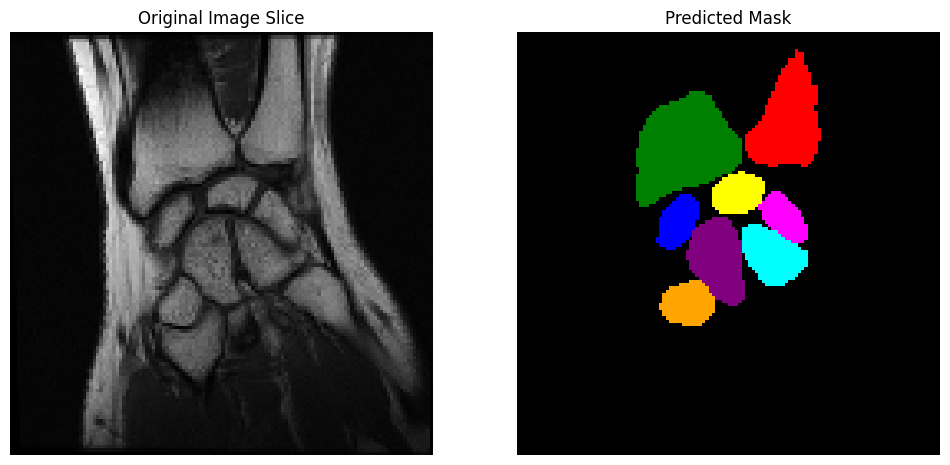

In [4]:
# Directory where predicted masks are saved
predicted_masks_dir = '/workspace/predicted_masks_unetr'

# Function to visualize a saved predicted mask alongside the original image
def display_saved_mask(mask_path, original_image_slice, slice_num):
    # Load the predicted mask from the .nii.gz file
    predicted_mask_nii = nib.load(mask_path)
    predicted_mask_data = predicted_mask_nii.get_fdata()
    predicted_mask_slice = predicted_mask_data[:, :, slice_num]  # Extract the specific slice

    # Creating a consistent colormap for visualization
    cmap = colors.ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple', 'brown', 'pink'])
    bounds = np.linspace(0, 11, 12)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(12, 6))

    # Displaying the original MRI image slice
    plt.subplot(1, 2, 1)
    plt.title("Original Image Slice")
    plt.imshow(original_image_slice, cmap='gray')
    plt.axis('off')

    # Displaying the predicted mask slice
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask_slice, cmap=cmap, norm=norm)
    plt.axis('off')

    plt.show()

# Example to display a specific mask and corresponding original slice
# Loading the original MRI image (.nii.gz file)
mri_image_path = '/workspace/data/imagesTs/UN064_0000.nii.gz'  # Replace with the correct file path
mri_image = nib.load(mri_image_path)
mri_image_data = mri_image.get_fdata()

# Selecting the slice you want to visualize
slice_num = 22  # Change this to the specific slice number you want to check
original_image_slice = mri_image_data[:, :, slice_num]  # Extracting the slice along the third dimension

# Constructing the path to the saved predicted mask
mask_filename = os.path.basename(mri_image_path)  # Getting the filename of the original image
mask_path = os.path.join(predicted_masks_dir, mask_filename)  # Constructing the corresponding mask path

# Displaying the saved predicted mask alongside the original image slice
display_saved_mask(mask_path, original_image_slice, slice_num)